https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

# Import Libraries

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data Training and Testing Data

In [2]:
X_train = np.load('../../Data/Train Test Dataset - Feature 5/X_train.npy')
X_test = np.load('../../Data/Train Test Dataset - Feature 5/X_test.npy')
y_train = np.load('../../Data/Train Test Dataset - Feature 5/y_train.npy')
y_test = np.load('../../Data/Train Test Dataset - Feature 5/y_test.npy')

# Loading individual models

In [3]:
ann_model = load_model('../../H5 Files/Feature 5/ANN_Architecture_5_Features.h5')
lstm_model = load_model('../../H5 Files/Feature 5/LSTM_Architecture_5_Features.h5')
gru_model = load_model('../../H5 Files/Feature 5/GRU_Architecture_5_Features.h5')

### Get predictions from base models on training data

In [4]:
# Get predictions from base models on training data
ann_pred = ann_model.predict(X_train)
lstm_pred = lstm_model.predict(X_train)
gru_pred = gru_model.predict(X_train)

19412/19412 [==============================] - 87s 4ms/step


In [5]:
# Stack predictions horizontally for meta-model training data
X_train_stacked = np.hstack((ann_pred, lstm_pred, gru_pred))

In [6]:
X_train_stacked.shape

(621158, 3)

### Get predictions from base models on test data

In [7]:
# Get predictions from base models on test data
ann_pred_test = ann_model.predict(X_test)
lstm_pred_test = lstm_model.predict(X_test)
gru_pred_test = gru_model.predict(X_test)

4853/4853 [==============================] - 22s 5ms/step


In [8]:
# Stack predictions horizontally for meta-model test data
X_test_stacked = np.hstack((ann_pred_test, lstm_pred_test, gru_pred_test))

In [9]:
X_test_stacked.shape

(155290, 3)

# Meta Learning - Artificial Neural Network

In [10]:
import numpy as np
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam

In [11]:
# Improved Meta-Learning Architecture
meta_model = Sequential()

# First Dense Layer with L2 regularization and Batch Normalization
meta_model.add(Dense(256, activation='relu', input_dim=X_train_stacked.shape[1], kernel_regularizer=l2(0.001)))
meta_model.add(BatchNormalization())  # Add batch normalization to improve training
meta_model.add(Dropout(0.3))  # Dropout for regularization

# Add second Dense Layer
meta_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
meta_model.add(BatchNormalization())  # Add batch normalization
meta_model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add third Dense Layer
meta_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.3))

# Output layer (binary classification)
meta_model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile model with Adam optimizer and low learning rate
meta_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_meta_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [13]:
start_time = time()
meta_model.fit(X_train_stacked, y_train, epochs=50, batch_size=1024, 
               validation_data=(X_test_stacked, y_test), 
               callbacks=[early_stopping, model_checkpoint])
end_time = time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/50
605/607 [============================>.] - ETA: 0s - loss: 0.3698 - accuracy: 0.9445
Epoch 1: val_loss improved from inf to 0.46455, saving model to best_meta_model.h5
607/607 [==============================] - 4s 5ms/step - loss: 0.3697 - accuracy: 0.9445 - val_loss: 0.4645 - val_accuracy: 0.8990
Epoch 2/50
607/607 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.9577
Epoch 2: val_loss improved from 0.46455 to 0.43840, saving model to best_meta_model.h5
607/607 [==============================] - 3s 5ms/step - loss: 0.2808 - accuracy: 0.9577 - val_loss: 0.4384 - val_accuracy: 0.8988
Epoch 3/50
605/607 [============================>.] - ETA: 0s - loss: 0.2404 - accuracy: 0.9579
Epoch 3: val_loss improved from 0.43840 to 0.39963, saving model to best_meta_model.h5
607/607 [==============================] - 3s 5ms/step - loss: 0.2403 - accuracy: 0.9579 - val_loss: 0.3996 - val_accuracy: 0.8990
Epoch 4/50
604/607 [============================>.] - ETA: 0s 

In [14]:
# Load the best model from the checkpoint
meta_model = load_model('best_meta_model.h5')

# Evaluate the Meta-Learning Model
start_time_test = time()
ensemble_pred_test = (meta_model.predict(X_test_stacked) > 0.5).astype(int)  
end_time_test = time()

test_time = end_time_test - start_time_test
print(f"Test time: {test_time:.2f} seconds")

4853/4853 [==============================] - 19s 4ms/step
Test time: 21.01 seconds


# Model Evaluation

## Importing Libraries - Evaluation

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Predict using meta-model

In [16]:
start_time_test = time()
ensemble_pred_test = meta_model.predict(X_test_stacked)
end_time_test = time()

test_time = end_time_test - start_time_test
test_time

print(f"Test time: {test_time:.2f} seconds")

4853/4853 [==============================] - 20s 4ms/step
Test time: 22.38 seconds


## Classification Report

In [18]:
ensemble_pred_test = (ensemble_pred_test > 0.5).astype(int)

classification_report = classification_report(y_test, ensemble_pred_test)
print(classification_report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     77676
           1       0.91      0.89      0.90     77614

    accuracy                           0.90    155290
   macro avg       0.90      0.90      0.90    155290
weighted avg       0.90      0.90      0.90    155290



## Confusion Matrix

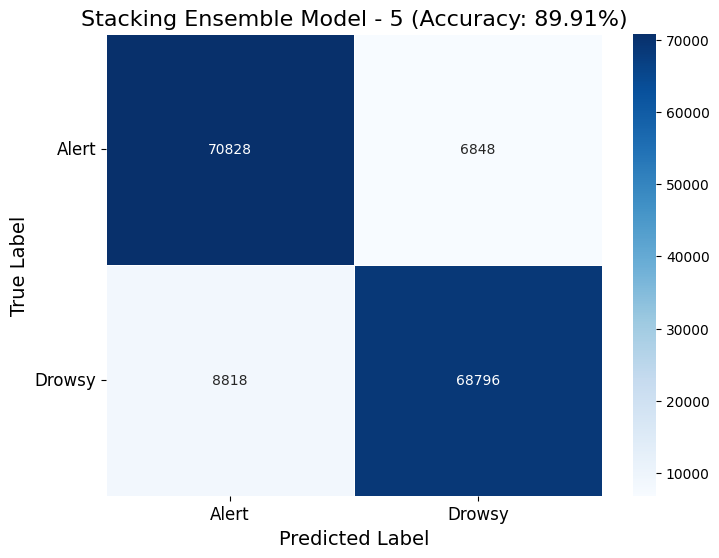

In [19]:
class_labels = ["Alert", "Drowsy"]

conf_matrix = confusion_matrix(y_test, ensemble_pred_test)
accuracy = accuracy_score(y_test, ensemble_pred_test) * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels, linewidths=.5)

plt.title(f'Stacking Ensemble Model - 5 (Accuracy: {accuracy:.2f}%)', fontsize=16)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

plt.xticks(rotation=0, fontsize=12)  
plt.yticks(rotation=0, fontsize=12)  

plt.show()

## Evaluation Metrics

In [20]:
accuracy = accuracy_score(y_test, ensemble_pred_test)
precision = precision_score(y_test, ensemble_pred_test)
recall = recall_score(y_test, ensemble_pred_test)
f1 = f1_score(y_test, ensemble_pred_test)
auc_roc = roc_auc_score(y_test, ensemble_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Accuracy: 0.8991177796380965
Precision: 0.909470678441119
Recall: 0.8863864766665808
F1-score: 0.8977802137571937
AUC-ROC: 0.899112698655655


## Receiver Operating Characteristic (ROC) Curve

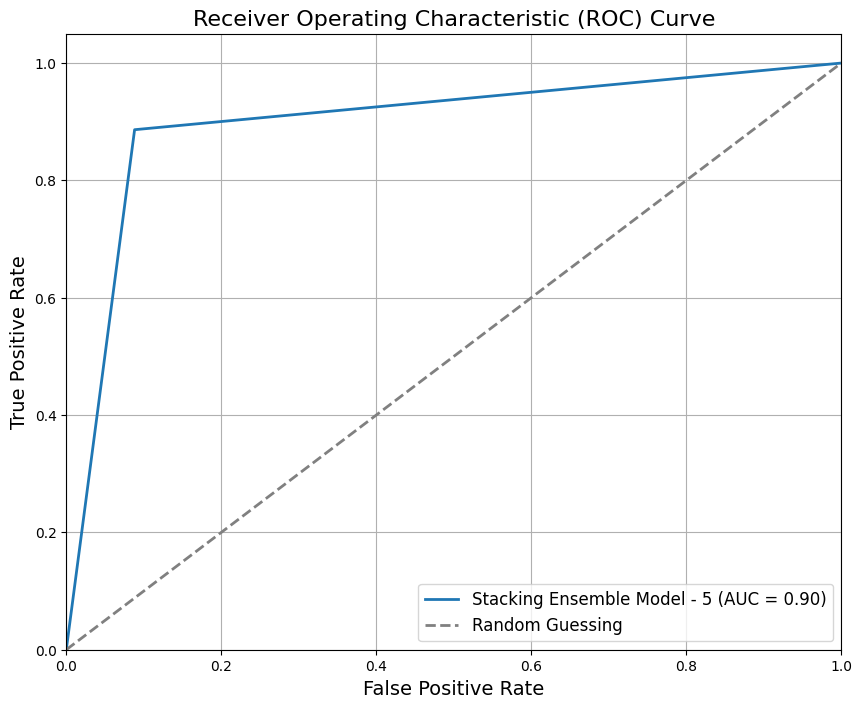

In [21]:
roc_data = {}

fpr, tpr, thresholds = roc_curve(y_test, ensemble_pred_test)
roc_auc = auc(fpr, tpr)
roc_data['Stacking Ensemble Model - 5'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

# Plotting ROC Curves 
plt.figure(figsize=(10, 8))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], lw=2, label=f'{name} (AUC = {data["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()

#### Stacking Ensemble References - 

https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28#:~:text=Stacking%20is%20a%20strong%20ensemble,stacked%20ensembles%20or%20stacked%20generalization.

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://www.javatpoint.com/stacking-in-machine-learning

https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/

#### Use this Figure - 
https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28#:~:text=Stacking%20is%20a%20strong%20ensemble,stacked%20ensembles%20or%20stacked%20generalization.